In [ ]:
import seaborn as sns
import plotly.express as px

In [ ]:
LDI_VERSION = 'v5'
import multiprocessing as mp
from functools import partial
from pathlib import Path

import re
import click
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import PchipInterpolator


import rra_climate_health.cli_options as clio
from rra_climate_health import paths
from rra_climate_health.data_prep import upstream_paths
from rra_climate_health.data import (
    DEFAULT_ROOT,
    ClimateMalnutritionData,
)

WEALTH_DATA_ROOT = Path(
    "/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/extractions"
)

WEALTH_DATA_PATHS = {
    "LSMS": WEALTH_DATA_ROOT / "LSMS_wealth.parquet",
    "DHS": WEALTH_DATA_ROOT / "DHS_wealth.parquet",
    "MICS": WEALTH_DATA_ROOT / "MICS_wealth.parquet",
}

SURVEY_DATA_ROOT = Path(
    "/mnt/team/integrated_analytics/pub/goalkeepers/goalkeepers_2024/data"
)

SDI_PATH = Path("/mnt/share/forecasting/data/7/past/sdi/20240531_gk24/sdi.nc")
#/mnt/team/integrated_analytics/pub/goalkeepers/goalkeepers_2024/data/wasting_stunting/wasting_stunting_combined_2024-10-11.csv
SURVEY_DATA_PATHS = {
    "bmi": {"gbd": SURVEY_DATA_ROOT / "bmi" / "bmi_data_outliered_wealth_rex.csv"},
    "cgf": {
        "gbd": SURVEY_DATA_ROOT
        / "wasting_stunting" / "wasting_stunting_combined_2024-10-11.csv",
        "lsae": "/mnt/share/limited_use/LIMITED_USE/LU_GEOSPATIAL/geo_matched/cgf/pre_collapse/cgf_lbw_2020_06_15.csv",
    },
    "wealth":  {
        "LSMS": WEALTH_DATA_ROOT / "LSMS_wealth.parquet",
        "DHS": WEALTH_DATA_ROOT / "DHS_wealth.parquet",
        "MICS": WEALTH_DATA_ROOT / "MICS_wealth.parquet",
    },
}

DATA_SOURCE_TYPE = {"stunting": "cgf", "wasting": "cgf", "underweight":"cgf", "low_adult_bmi": "bmi"}
MEASURES_IN_SOURCE = {"cgf": ["stunting", "wasting", "underweight"], "bmi": ["low_adult_bmi"]}

############################
# Wasting/Stunting columns #
############################

def examine_survey_schema(df: pd.DataFrame, columns: list[str]) -> None:
    print("Records:", len(df))
    print()

    template = "{:<20} {:>10} {:>10} {:>10}"
    header = template.format("COLUMN", "N_UNIQUE", "N_NULL", "DTYPE")

    print(header)
    print("=" * len(header))
    for col in columns:
        unique = df[col].nunique()
        nulls = df[col].isna().sum()
        dtype = str(df[col].dtype)
        print(template.format(col, unique, nulls, dtype))


COLUMN_NAME_TRANSLATOR = {
    "country": "ihme_loc_id",
    "year_start": "year_start",
    "end_year": "year_end",
    "psu_id": "psu",
    "strata_id": "strata",
    "sex": "sex_id",
    "age_mo": "age_month",
    "stunting_mod_b": "stunting",
    "wasting_mod_b": "wasting",
    "underweight_mod_b": "underweight",
    "HAZ_b2": "stunting",
    "WHZ_b2": "wasting",
    "WAZ_b2": "underweight",
    "latnum": "lat",
    "longnum": "long",
    "latitude": "lat",
    "longitude": "long",
}


def merge_left_without_inflating(df_left, df_right, **kwargs):
    """Merge left without inflating the left dataframe."""
    df = df_left.merge(df_right, how="left", **kwargs)
    if len(df) != len(df_left):
        msg = "Mismatch in length of data and merged data."
        raise RuntimeError(msg)
    return df


def get_climate_vars_for_year(
    year_df: pd.DataFrame,
    climate_variables: list[str],
    lat_col: str = "lat",
    long_col: str = "long",
    year_col: str = "int_year",
) -> pd.DataFrame:
    if year_df[year_col].nunique() != 1:
        msg = "Multiple years in climate data."
        raise ValueError(msg)

    yr = year_df[year_col].iloc[0]

    temp_df = year_df.copy()
    lats = xr.DataArray(temp_df[lat_col], dims="point")
    lons = xr.DataArray(temp_df[long_col], dims="point")
    years = xr.DataArray(temp_df[year_col], dims="point")
    for climate_variable in climate_variables:
        #climate_ds = ClimateMalnutritionData(Path(DEFAULT_ROOT)/'stunting').load_climate_raster(climate_variable, 'ssp245', yr, 0)
        # Temporary workaround for climate data loading
        climate_ds = xr.open_dataset(f'/mnt/share/erf/climate_downscale/results/annual/raw/historical/{climate_variable}/{yr}_era5.nc')['value']
        temp_df[climate_variable] = (
            climate_ds.sel(latitude=lats, longitude=lons, method="nearest")
            .to_numpy().flatten() #the flatten also wasn't there before
        )
    return temp_df


def get_climate_vars_for_dataframe(
    df: pd.DataFrame,
    lat_col: str = "lat",
    long_col: str = "long",
    year_col: str = "int_year",
) -> pd.DataFrame:
    var_names = [
        'mean_temperature', 'days_over_30C', 'precipitation_days', 
        'total_precipitation', 'mean_low_temperature', 'mean_high_temperature',
        'relative_humidity', 'days_over_26C', 'days_over_27C', 'days_over_28C',
        'days_over_29C', 'days_over_31C', 'days_over_32C', 'days_over_33C',
    ]

    unique_coords = df[[lat_col, long_col, year_col]].drop_duplicates()

    df_splits = [year_df for _, year_df in unique_coords.groupby(year_col)]
    p = mp.Pool(processes=25)
    results_df = pd.concat(
        p.map(
            partial(get_climate_vars_for_year, climate_variables=var_names), df_splits
        )
    )
    p.close()
    p.join()
    return results_df

ELEVATION_FILEPATH = '/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/elevation/GLOBE_DEM_MOSAIC_Y2016M02D09.TIF'
def get_elevation_for_dataframe(
    df: pd.DataFrame, lat_col: str = "lat", long_col: str = "long"
) -> pd.DataFrame:
    unique_coords = df[[lat_col, long_col]].drop_duplicates()
    elevation_ds: xr.Dataset = rioxarray.open_rasterio(ELEVATION_FILEPATH, masked=True)  # type: ignore[assignment]
    unique_coords["elevation"] = elevation_ds.sel(
        x=xr.DataArray(unique_coords.long, dims="z"),
        y=xr.DataArray(unique_coords.lat, dims="z"),
        band=1,
        method="nearest",
    ).to_numpy()

    unique_coords["elevation"] = unique_coords["elevation"].fillna(0)
    unique_coords["elevation"] = unique_coords["elevation"].astype(int)
    results_df = merge_left_without_inflating(df, unique_coords, on=[lat_col, long_col])
    if results_df["elevation"].isna().any():
        msg = "Null elevation values."
        raise RuntimeError(msg)
    return results_df


def get_ldipc_from_asset_score(
    asset_df: pd.DataFrame,
    cm_data,  # instance providing the load_ldi_distributions() method
    asset_score_col: str = "wealth_index_dhs",
    year_df_col: str = "year_start",
    *,
    ldi_version="",
    weights_col="pweight",
    plot: bool = True,
    plot_pdf_path: str = "./nid_plots.pdf",
) -> pd.DataFrame:
    """
    Calculates LDI-PC from asset scores using four methods:
      (1) Unweighted percentiles, direct interpolation (no matching)
      (2) Weighted percentiles, direct interpolation (no matching)
      (3) Unweighted percentiles with distribution matching
      (4) Weighted percentiles with distribution matching

    Additionally, if plotting is enabled, a single PDF is produced (at plot_pdf_path)
    containing one page per NID. Each page shows:
        - The reference (target) LDI distribution (which is always 10 points)
        - The 4 computed LDI-PC curves.
    
    The dynamic grid used for matching and plotting is determined based on the number
    of observations in the NID (nid_df).

    Parameters:
      asset_df         : DataFrame containing asset scores and related columns.
      cm_data          : Object providing the load_ldi_distributions() method.
      asset_score_col  : Column name for the asset score.
      year_df_col      : Column name for the year.
      ldi_version      : Version identifier for LDI distribution.
      weights_col      : Column name for weights.
      plot             : If True, generate a PDF with NID plots.
      plot_pdf_path    : File path for the output PDF containing the plots.

    Returns:
      A DataFrame with additional columns:
        - ldi_pc_unweighted_no_match
        - ldi_pc_weighted_no_match
        - ldi_pc_unweighted_match
        - ldi_pc_weighted_match
    """
    # Load LDI distribution data
    ldi = cm_data.load_ldi_distributions(geospecificity="national", version=ldi_version)
    if "scenario" in ldi.columns:
        if 0 in ldi.scenario.unique():
            ldi = ldi.loc[ldi["scenario"] == 0].drop("scenario", axis=1)
        elif 4.5 in ldi.scenario.unique():
            ldi = ldi.loc[ldi["scenario"] == 4.5].drop("scenario", axis=1)
        else:
            raise ValueError("No valid scenario in LDI data.")
    print("Calculating four versions of LDI-PC (weighted/unweighted, match/no-match).")
    
    # Optionally initialize PdfPages for a single PDF with all plots.
    if plot:
        pdf_pages = PdfPages(plot_pdf_path)
    
    results = []
    
    for nid in asset_df.nid.unique():
        nid_df = (
            asset_df.loc[asset_df.nid == nid]
            .copy()
            .sort_values(["nid", "ihme_loc_id", year_df_col, asset_score_col])
        )
        
        # Choose year: if multiple, use the earliest
        if nid_df[year_df_col].nunique() > 1:
            print(f"Multiple years for NID {nid}: {nid_df[year_df_col].unique()}")
            year = nid_df[year_df_col].min()
        else:
            year = nid_df[year_df_col].iloc[0]
        
        # Ensure a single location for this NID
        if nid_df.ihme_loc_id.nunique() > 1:
            raise ValueError(f"Multiple locations for NID {nid}")
        ihme_loc_id = nid_df.ihme_loc_id.iloc[0]
        
        # Compute percentiles: unweighted and weighted.
        nid_df["unweighted_population_percentile"] = nid_df[asset_score_col].rank(pct=True)
        nid_df["cum_weight"] = nid_df[weights_col].cumsum()
        total_weight = nid_df[weights_col].sum()
        nid_df["weighted_population_percentile"] = nid_df["cum_weight"] / total_weight
        
        # Get LDI data for this location and year; sort by population_percentile.
        ldi_df = ldi.loc[(ldi.ihme_loc_id == ihme_loc_id) & (ldi.year_id == year)]
        ldi_df = ldi_df.sort_values("population_percentile")
        if ldi_df.empty:
            raise ValueError(f"No LDI data for NID {nid} in year {year}")
        
        # Determine dynamic grid resolution based on survey data.
        # Since the target distribution always has 10 points, we use the NID data resolution.
        grid_points = max(1000, min(1000000, len(nid_df) * 100))
        #print(f"Using {grid_points} points for NID {nid}.")
        dynamic_grid = np.linspace(0, 1, grid_points)
        
        # Build the interpolator from the target (LDI) distribution.
        ldi_interpolator = PchipInterpolator(ldi_df["population_percentile"], ldi_df["ldipc"])
        # Evaluate reference LDI distribution on the dynamic grid.
        ldi_ref = ldi_interpolator(dynamic_grid)
        
        # Direct interpolation (no matching) for both unweighted and weighted.
        unweighted_no_match = ldi_interpolator(nid_df["unweighted_population_percentile"])
        weighted_no_match = ldi_interpolator(nid_df["weighted_population_percentile"])
        
        # Evaluate LDI distribution on the grid for matching purposes.
        interpolated_income_distrib = ldi_interpolator(dynamic_grid)

        #ldi_value_at_80th_percentile = ldi_interpolator(0.8)
        
        # Define the matching procedure.
        def match_distribution(pop_pct, asset_scores):
            """
            For a given set of population percentiles and asset scores,
            iterate over a range of clipping thresholds of the interpolated LDI
            distribution. The candidate curve that minimizes the absolute difference
            between its scaled version and the scaled asset scores is returned.
            """
            scaled_asset = (asset_scores - asset_scores.min()) / (asset_scores.max() - asset_scores.min())
            best_candidate = None
            minimum_difference = np.inf
            # Try thresholds from 25% to 100% in 76 steps.
            for threshold_quantile in np.linspace(0.8, 1, 21):
                threshold_value = np.quantile(interpolated_income_distrib, threshold_quantile)
                clipped_income = interpolated_income_distrib[interpolated_income_distrib <= threshold_value]
                if len(clipped_income) < 2:
                    continue
                clipped_interpolator = PchipInterpolator(
                    np.linspace(0, 1, len(clipped_income)), clipped_income
                )
                candidate = clipped_interpolator(pop_pct)
                scaled_candidate = (candidate - candidate.min()) / (candidate.max() - candidate.min())
                diff = np.abs(scaled_candidate - scaled_asset).sum()
                if diff < minimum_difference:
                    minimum_difference = diff
                    best_candidate = candidate
            return best_candidate
        
        unweighted_match = match_distribution(
            nid_df["unweighted_population_percentile"], nid_df[asset_score_col]
        )
        weighted_match = match_distribution(
            nid_df["weighted_population_percentile"], nid_df[asset_score_col]
        )
        
        # Store the four computed versions in new columns.
        nid_df["ldipc_unweighted_no_match"] = unweighted_no_match
        nid_df["ldipc_weighted_no_match"] = weighted_no_match
        nid_df["ldipc_unweighted_match"] = unweighted_match
        nid_df["ldipc_weighted_match"] = weighted_match
        
        # Plotting per NID if enabled.
        if plot:
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # Plot the reference LDI distribution (flipped axes).
            ax.plot(ldi_ref, dynamic_grid, label="Reference LDI", linestyle="--", color="black")
            
            # Plot the computed LDI-PC curves with flipped axes.
            sorted_unw = sorted(zip(unweighted_no_match, nid_df["unweighted_population_percentile"]))
            ax.plot(*zip(*sorted_unw), label="Unweighted No Match")
            
            sorted_w = sorted(zip(weighted_no_match, nid_df["weighted_population_percentile"]))
            ax.plot(*zip(*sorted_w), label="Weighted No Match")
            
            sorted_unw_match = sorted(zip(unweighted_match, nid_df["unweighted_population_percentile"]))
            ax.plot(*zip(*sorted_unw_match), label="Unweighted Match")
            
            sorted_w_match = sorted(zip(weighted_match, nid_df["weighted_population_percentile"]))
            ax.plot(*zip(*sorted_w_match), label="Weighted Match")
            
            # Compute scaling parameters for wealth index.
            wealth_min = nid_df[asset_score_col].min()
            wealth_max = nid_df[asset_score_col].max()
            ldi_min = ldi_ref.min()
            ldi_max = ldi_ref.max()
            
            # Define transformation functions for mapping wealth index to LDI range and vice versa.
            def wealth_to_ldi(w):
                return (w - wealth_min) / (wealth_max - wealth_min) * (ldi_max - ldi_min) + ldi_min

            def ldi_to_wealth(x):
                return (x - ldi_min) / (ldi_max - ldi_min) * (wealth_max - wealth_min) + wealth_min

            # Plot the original wealth index distribution, scaled to LDI range.
            sorted_wealth = sorted(zip(nid_df[asset_score_col], nid_df["unweighted_population_percentile"]))
            scaled_sorted_wealth = [(wealth_to_ldi(w), p) for w, p in sorted_wealth]
            ax.plot(*zip(*scaled_sorted_wealth), label="Wealth Index", linestyle=":", color="blue")

            sorted_wealth = sorted(zip(nid_df[asset_score_col], nid_df["weighted_population_percentile"]))
            scaled_sorted_wealth = [(wealth_to_ldi(w), p) for w, p in sorted_wealth]
            ax.plot(*zip(*scaled_sorted_wealth), label="Wealth Index (weighted)", linestyle=":", color="green")
            
            # Set labels and title.
            ax.set_xlabel("LDI-PC")
            ax.set_ylabel("Population Percentile")
            ax.set_title(f"NID {nid} | Year: {year} | ihme_loc_id: {ihme_loc_id}")
            ax.legend()
            ax.grid(True)
            
            # Add a secondary x-axis for Wealth Index.
            secax = ax.secondary_xaxis('top', functions=(ldi_to_wealth, wealth_to_ldi))
            secax.set_xlabel("Wealth Index")
            
            pdf_pages.savefig(fig)
            plt.close(fig)

        
        results.append(nid_df)
    
    if plot:
        pdf_pages.close()
    
    asset_df_ldipc = pd.concat(results)
    new_cols = [
        "ldipc_unweighted_no_match",
        "ldipc_weighted_no_match",
        "ldipc_unweighted_match",
        "ldipc_weighted_match",
    ]
    if asset_df_ldipc[new_cols].isna().sum().sum() != 0:
        raise RuntimeError("Null LDI-PC values in one of the methods.")
    if len(asset_df_ldipc) != len(asset_df):
        raise RuntimeError("Mismatch in length of asset data and LDI-PC data.")
    return asset_df_ldipc  # type: ignore[no-any-return]


WEALTH_DATASET_COMMON_COLUMNS = [
        "ihme_loc_id",
        "nid",
        "psu",
        "strata",
        "hh_id",
        "hhweight",
        "lat",
        "long",
        "year_start",
        "geospatial_id"]

def filter_point_data(df: pd.DataFrame) -> pd.DataFrame:
    """Keep only rows with point == 1."""
    return df[df["point"] == 1]

def validate_lat_long_uniqueness(df: pd.DataFrame) -> None:
    """Ensure that for each household (nid, psu, hh_id), lat and long are unique."""
    grouped = df.groupby(["nid", "psu", "hh_id"])
    if not (grouped["lat"].nunique().eq(1) & grouped["long"].nunique().eq(1)).all():
        raise ValueError("Multiple latitudes or longitudes for the same nid, psu, and hh_id.")

def validate_no_duplicate_entries(df: pd.DataFrame, group_cols: list, error_msg: str) -> None:
    """Ensure that grouping by group_cols gives a single entry per group."""
    if df.groupby(group_cols).size().max() != 1:
        raise ValueError(error_msg)

def common_validations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform validations common to all wealth datasets:
      - Check lat/long uniqueness.
      - Check no duplicate entries by (nid, psu, hh_id) and related groupings.
      - Merge with location metadata and cast types.
    """
    validate_lat_long_uniqueness(df)
    validate_no_duplicate_entries(df, ["nid", "psu", "hh_id"],
                                  "Multiple entries for the same nid, psu, and hh_id.")
    
    if df.groupby(["nid", "hh_id", "year_start", "psu", "geospatial_id"]).size().max() != 1:
        raise ValueError("Multiple entries for the same nid, psu, hh_id, and year.")
    if df.groupby(["nid", "hh_id", "year_start", "psu"]).size().max() != 1:
        raise ValueError("Multiple entries for the same nid, psu, hh_id, and year.")
    
    # Load location metadata here (only used within these validations)
    loc_meta = pd.read_parquet(paths.FHS_LOCATION_METADATA_FILEPATH)
    df = merge_left_without_inflating(df, loc_meta[["location_id", "ihme_loc_id"]], on="ihme_loc_id")
    if df.location_id.isna().any():
        raise RuntimeError("Null location IDs.")
    
    df["year_start"] = df["year_start"].astype(int)
    df["nid"] = df["nid"].astype(int)
    return df

def get_DHS_wealth_dataset() -> pd.DataFrame:
    wealth_raw = pd.read_parquet(SURVEY_DATA_PATHS["wealth"]["DHS"])
    df = filter_point_data(wealth_raw)
    
    # Specific renaming for DHS
    df = df.rename(columns={
        "wealth_score": "wealth_index_dhs",
        "iso3": "ihme_loc_id",
        "weight": "hhweight",
    })
    df = df.rename(columns=COLUMN_NAME_TRANSLATOR)
    
    # Use the global column order and remove duplicates
    df = df[WEALTH_DATASET_COMMON_COLUMNS + ['wealth_index_dhs']].drop_duplicates()
    
    # Remove problematic NIDs
    bad_entries = df.groupby(["nid", "hh_id", "year_start", "psu"]).size()
    bad_nids = list(bad_entries[bad_entries > 1].reset_index().nid.unique())
    bad_nids = [*bad_nids, 20315, 20301, 20537]
    df = df[~df.nid.isin(bad_nids)]
    
    df = common_validations(df)
    return df

def get_MICS_wealth_dataset() -> pd.DataFrame:
    wealth_raw = pd.read_parquet(SURVEY_DATA_PATHS["wealth"]["MICS"])
    df = filter_point_data(wealth_raw)
    
    # Specific renaming for MICS
    df = df.rename(columns={
        "wealth_score": "wealth_index_dhs",
        "iso3": "ihme_loc_id",
    })
    df = df.rename(columns=COLUMN_NAME_TRANSLATOR)
    
    df = df[WEALTH_DATASET_COMMON_COLUMNS + ['wealth_index_dhs']].drop_duplicates()
    
    # For NID 7618, use geospatial_id as the hh_id
    df.loc[df.nid == 7618, "hh_id"] = df.loc[df.nid == 7618, "geospatial_id"]
    # Truncate ihme_loc_id to country-level (first 3 characters)
    df['ihme_loc_id'] = df['ihme_loc_id'].str[:3]
    
    df = common_validations(df)
    return df

def get_LSMS_wealth_dataset() -> pd.DataFrame:
    wealth_raw = pd.read_parquet(SURVEY_DATA_PATHS["wealth"]["LSMS"])
    df = filter_point_data(wealth_raw)
    
    # Exclude NIDs with no wealth measure available
    wealth_measure_availability = df.groupby('nid').apply(
        lambda x: x[['income', 'expenditure', 'consumption']].isna().all().all(),
        include_groups=False
    )
    nids_without_wealth = wealth_measure_availability[wealth_measure_availability].index.astype(int)
    df = df[~df.nid.isin(nids_without_wealth)].reset_index(drop=True)
    
    # Choose the best available wealth measure, preferring income, then consumption, then expenditure
    wealth_measure = df.groupby('nid').apply(
        lambda x: x[['income', 'expenditure', 'consumption']].isna().mean().idxmin(),
        include_groups=False
    ).reset_index()
    wealth_measure.columns = ['nid', 'wealth_measure']
    df = df.merge(wealth_measure, on='nid', how='left')
    df['wealth_measurement'] = df.apply(lambda row: row[row['wealth_measure']], axis=1)
    
    # Remove problematic NID with multiple measures
    df = df[~df.nid.isin([283013])].reset_index(drop=True)
    
    # Use hhweight if available; otherwise, use pweight
    df['hhweight'] = df['hhweight'].combine_first(df['pweight']).astype(float)
    
    # Validate that each household has a unique wealth measurement
    grouped = df.groupby(['nid', 'hh_id', 'psu', 'geospatial_id'])
    if not (grouped['wealth_measurement'].nunique().eq(1)).all():
        raise ValueError("Multiple wealth measurements for the same household.")
    
    df = df.rename(columns={
        "iso3": "ihme_loc_id",
    })
    df = df.rename(columns=COLUMN_NAME_TRANSLATOR)
    
    df = df[WEALTH_DATASET_COMMON_COLUMNS + ['wealth_measurement', 'wealth_measure']].drop_duplicates()
    
    # Truncate ihme_loc_id to country-level (first 3 characters)
    df['ihme_loc_id'] = df['ihme_loc_id'].str[:3]
    
    df = common_validations(df)
    return df


def assign_age_group(df: pd.DataFrame) -> pd.DataFrame:
    age_group_spans = pd.read_parquet(paths.AGE_SPANS_FILEPATH)
    age_group_spans = age_group_spans.query("age_group_id in [388, 389, 238, 34]")
    df["age_group_id"] = np.nan
    for _, row in age_group_spans.iterrows():
        df.loc[
            (df.age_year >= row.age_group_years_start.round(5))
            & (df.age_year < row.age_group_years_end),
            "age_group_id",
        ] = row.age_group_id
    for _, row in age_group_spans.iterrows():
        df.loc[
            (df.age_group_id.isna())
            & (df.age_year == 0)
            & (df.age_month / 12 >= row.age_group_years_start)
            & (df.age_month / 12 < row.age_group_years_end),
            "age_group_id",
        ] = row.age_group_id
    # Fix for some kids that had age_year = 0.076 but month == 1
    age_one_month, age_id_one_month = 0.076, 388
    df.loc[
        (df.age_group_id.isna()) & (df.age_year > age_one_month) & (df.age_month == 1),
        "age_group_id",
    ] = age_id_one_month

    age_id_map = {
        388: 4,
        389: 4,
        238: 5,
        34: 5,
    }
    df["age_group_id_agg"] = df["age_group_id"].map(age_id_map)
    return df


def assign_lbd_admin2_location_id(
    data: gpd.GeoDataFrame, lat_col: str = "lat", long_col: str = "long"
) -> pd.DataFrame:
    lbd_admin2_metadata_filepath = (
        ClimateMalnutritionData._PROCESSED_DATA_ROOT / "ihme" / "lbd_admin2.parquet"  # noqa: SLF001
    )
    admin2_shapes = (
        gpd.read_parquet(lbd_admin2_metadata_filepath)[["loc_id", "geometry"]]
        .rename(columns={"loc_id": "lbd_admin2_id"})
        .to_crs("ESRI:54009")
    )
    if "lbd_admin2_id" in data.columns:
        msg = "lbd_admin2_id column already in data."
        raise ValueError(msg)

    cgf_coords = data[[lat_col, long_col]].drop_duplicates()
    cgf_coords = gpd.GeoDataFrame(
        cgf_coords, geometry=gpd.points_from_xy(cgf_coords.long, cgf_coords.lat)
    )
    cgf_coords = cgf_coords.set_crs("WGS84").to_crs("ESRI:54009")

    lencheck = len(cgf_coords)
    cgf_coords = cgf_coords.sjoin_nearest(
        admin2_shapes, how="left", distance_col="distance"
    )
    # There's a point in Colombia that is included in two different admin2s so it gets duplicated; dropping the wrong location for it
    cgf_coords = cgf_coords.query(
        f"not({lat_col} == 10.935365 and {long_col} == -74.764815 and lbd_admin2_id == 55124)"
    )
    if len(cgf_coords) != lencheck:
        msg = "Mismatch in length of data and merged data."
        raise RuntimeError(msg)

    result = merge_left_without_inflating(data, cgf_coords[[lat_col, long_col, "lbd_admin2_id"]], on=[lat_col, long_col])
    return result  # type: ignore[no-any-return]


def assign_sdi(df: pd.DataFrame, year_col: str = "year_start") -> pd.DataFrame:
    sdi = xr.open_dataset(SDI_PATH)
    sdi = sdi.mean(dim="draw")
    return df.merge(
        sdi.to_dataframe(),
        left_on=["location_id", year_col],
        right_index=True,
        how="left",
    )


@click.command()  # type: ignore[arg-type]
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_source_type(allow_all=False)
def run_training_data_prep(output_root: str, source_type: str) -> None:
    """Run training data prep."""
    print(f"Running training data prep for {source_type}...")
    # for src in source_type:
    run_training_data_prep_main(output_root, source_type)

def clean_hh_id(row):
    hh_id_str = str(row['hh_id'])
    geo_str = str(row['geospatial_id'])
    # Match one or more leading zeros followed by the geospatial_id at the start
    pattern = r'^0+' + re.escape(geo_str)
    # Remove the matched pattern (if found)
    cleaned = re.sub(pattern, '', hh_id_str)
    # Strip remaining leading zeros and handle empty results
    cleaned = cleaned.lstrip('0') or '0'
    return cleaned


In [ ]:
anemia_team_df_raw = pd.read_csv('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/extractions/anemia/anemia_extracts_compiled_09_02_2025.csv')
anemia_team_df = anemia_team_df_raw.copy()
anemia_team_df.columns.to_list()
anemia_nids = anemia_team_df.nid.unique()

# Prepping wealth dataset
wealth_anemia_df = get_DHS_wealth_dataset()
wealth_anemia_df = wealth_anemia_df.query("nid in @anemia_nids")
cm_data = ClimateMalnutritionData(Path(DEFAULT_ROOT)/'anemia')
wealth_anemia_df = get_ldipc_from_asset_score(
        wealth_anemia_df, cm_data, asset_score_col="wealth_index_dhs", weights_col="hhweight",
        plot_pdf_path=Path(DEFAULT_ROOT) / "input"/ "ldi_plots"/ "anemia_dhs_plots.pdf",
        ldi_version = LDI_VERSION,
    )

#prepping for merge, aligning column names and cleaning columns
anemia_team_df = anemia_team_df_raw[['ihme_loc_id', 'nid', 'survey_name', 'year_start', 'year_end', 'urban', 'geospatial_id', 'pweight', 
    'psu_id', 'strata_id',  'hh_id', 'line_id', 'sex_id', 'age_year', 'age_month', 'int_year', 
    'anemia_anemic_brinda', 'anemia_mod_sev_brinda', 'latnum', 'longnum',]]# 'pregnant', 'last_menstrual_period', 'latitude', 'longitude']]
anemia_team_df = anemia_team_df.rename(columns=COLUMN_NAME_TRANSLATOR)
anemia_team_df = anemia_team_df.rename(
    columns={"latitude": "lat", "longitude": "long", "hh_id": "old_hh_id"}
)
anemia_team_df["hh_id"] = anemia_team_df["old_hh_id"].str.split(r"[_ ]").str[-1]
anemia_team_df["psu"] = anemia_team_df["psu"].astype(int)
anemia_team_df["hh_id"] = anemia_team_df.apply(clean_hh_id, axis=1)


wealth_anemia_df = wealth_anemia_df.rename(columns={"hh_id": "old_hh_id"})
wealth_anemia_df["hh_id"] = wealth_anemia_df["old_hh_id"].str.split(r"[_ ]").str[-1]
wealth_anemia_df["psu"] = wealth_anemia_df["psu"].astype(int)
wealth_anemia_df["hh_id"] = wealth_anemia_df.apply(clean_hh_id, axis=1)


/tmp/ipykernel_2894241/3553098556.py:1: DtypeWarning: Columns (20,23,25,26,27,28,65,66,68,69,70,71,72,74,76,77,78,83,103,104,105,106,107,108,110,116,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  anemia_team_df_raw = pd.read_csv('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/extractions/anemia/anemia_extracts_compiled_09_02_2025.csv')


In [ ]:
merge_cols = ["nid", "ihme_loc_id", "hh_id", "psu", "year_start"]
anemia_merged = merge_left_without_inflating(anemia_team_df.drop(columns=["old_hh_id"]), wealth_anemia_df.drop(columns=['lat', 'long']), on=merge_cols)

#Calculate proportion of NA and filter out nids with too much wealth missingness (bad merges)
merged_na_props = (anemia_merged.groupby(['nid']).ldipc_weighted_no_match.count() / anemia_merged.groupby(['nid']).ldipc_weighted_no_match.size())
merged_nids = merged_na_props[merged_na_props > 0.95].index.to_list()
anemia_df = anemia_merged.query("nid in @merged_nids").copy()

# Assign age group
anemia_df = assign_age_group(anemia_df, )
anemia_df = anemia_df.dropna(subset=["age_group_id"])

# Take out data with invalid lat and long
anemia_df = anemia_df.dropna(subset=["lat", "long"])
anemia_df = anemia_df.query("lat != 0 and long != 0")

# Merge with climate data
print("Processing climate data...")
climate_vars = get_climate_vars_for_dataframe(anemia_df)
anemia_df = merge_left_without_inflating(anemia_df, climate_vars, on=["int_year", "lat", "long"])

print("Adding elevation data...")
anemia_df = get_elevation_for_dataframe(anemia_df)

anemia_df = assign_lbd_admin2_location_id(anemia_df)


In [199]:
agg_df = anemia_df.groupby(['nid', 'ihme_loc_id', 'year_start'], as_index=False).mean(numeric_only=True).rename(columns={'ldipc_weighted_no_match':'consumption', 'anemia_mod_sev_brinda':'modsev_anemia_prev', 'anemia_anemic_brinda':'total_anemia_prev'})

In [222]:

px.scatter(agg_df, x='mean_temperature', y='total_anemia_prev', color='ihme_loc_id')

/tmp/ipykernel_2894241/3077287638.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='days_over_30C_bin', ylabel='consumption'>

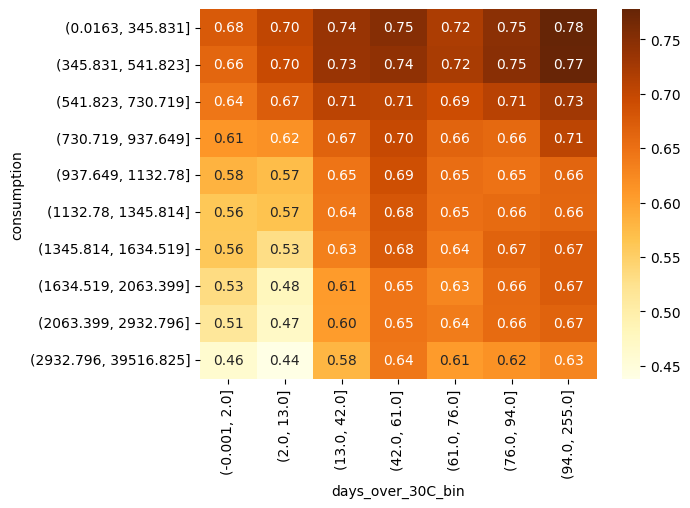

In [224]:
columns_to_bin = ['mean_temperature', 'total_precipitation', 'relative_humidity', 'mean_high_temperature', 'mean_low_temperature', 'precipitation_days', 'days_over_30C', 'days_over_26C']
heatmap_df = anemia_df.copy()#.query("ihme_loc_id == 'ETH'")
for col in columns_to_bin:
    heatmap_df[f'{col}_bin'] = pd.qcut(heatmap_df[col], 10, retbins=False, duplicates='drop')
heatmap_df["consumption"], ldi_bins = pd.qcut(heatmap_df.ldipc_weighted_no_match, 10, retbins=True)
col = 'days_over_30C'
sns.heatmap(
        heatmap_df.groupby(["consumption", f"{col}_bin"])['anemia_anemic_brinda'].mean().unstack(),
        annot=True,
        fmt=".2f",
        cmap='YlOrBr',
    )
